# Artificial dataset - Correlation analysis

In this notebook, we'll look into the Pearson correlation between the different classes generated for the artificial dataset.

In [1]:
%matplotlib inline
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

import os, sys, ast, pdb
import pickle
import numpy as np
import pandas as pd

sys.path.append('../')
import utils
import make_figures as mf

paths = utils.get_project_paths()

## PARAMETERS COMMON TO ALL SIMULATIONS ##
seq_length = 300000
n_tests = 300
T = 0.4
tree_depth = 5
bf_ratio = 0.1

import result_loader as ld
utils.format_paper()

n_batches = 10
lr=0.01
linear_ratio_for_artificial_seq = 8
artificial_seq_len = 200

sim_directory = utils.get_simus_directory()

In [91]:
import seaborn as sns
import random

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def heatmap(x, y, size, color, size_scale=1):
    fig = plt.figure(figsize=(15,15))
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1, figure=fig) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color),
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right
    
    return fig

In [76]:
bit_flips_per_lvl = int(bf_ratio*artificial_seq_len)
fs_name = "ultra_vs_rb2_d{depth_:d}_{bf_:d}bits".format(
    depth_ = tree_depth,
    bf_ = bit_flips_per_lvl
)
rs_names = {
    "d{depth_:d}UltraMixed{bf_:d}bits".format(
        depth_ = tree_depth,
        bf_ = bit_flips_per_lvl
    ): 0,
    "d{depth_:d}UltraUnmixed{bf_:d}bits".format(
        depth_ = tree_depth,
        bf_ = bit_flips_per_lvl
    ): 0.12,
    "d{depth_:d}RbMixed{bf_:d}bits".format(
        depth_ = tree_depth,
        bf_ = bit_flips_per_lvl
    ): 0.5,
    "d{depth_:d}RbUnmixed{bf_:d}bits".format(
        depth_ = tree_depth,
        bf_ = bit_flips_per_lvl
    ): 0.62,
    "d{depth_:d}Unif{bf_:d}bits".format(
        depth_ = tree_depth,
        bf_ = bit_flips_per_lvl
    ): 0
}
accuracy_to_compare = [
    (
        "d{depth_:d}UltraMixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}RbMixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}Unif{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl)
    ),
    (
        "d{depth_:d}UltraUnmixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}RbUnmixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}Unif{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl)
    ),
    (
        "d{depth_:d}UltraMixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}UltraUnmixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}Unif{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl)
    ),
    (
        "d{depth_:d}RbMixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}RbUnmixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
        "d{depth_:d}Unif{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl)
    )
]
accuracy_plot_style = "comp"
rs_for_lbl_plots = (
    "d{depth_:d}UltraMixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl),
    "d{depth_:d}RbMixed{bf_:d}bits".format(depth_ = tree_depth, bf_ = bit_flips_per_lvl)
)

In [80]:
fs = mf.FigureSet(fs_name=fs_name, rs_names=rs_names, accuracy_to_compare=accuracy_to_compare, accuracy_plot_style=accuracy_plot_style, rs_for_lbl_plots=rs_for_lbl_plots, seq_length=300000, n_tests=300, artificial_seq_len=200)

Loading result set for Ultrametric depth 5 (mixed tree leaves, 20bits/lvl)...
Loading result set for Ultrametric depth 5 (unmixed tree leaves, 20bits/lvl)...
Loading result set for Random blocks depth 5 (mixed tree leaves, 20bits/lvl)...
Loading result set for Random blocks depth 5 (unmixed tree leaves, 20bits/lvl)...
Loading result set for Uniform depth 5 (20bits/lvl)...


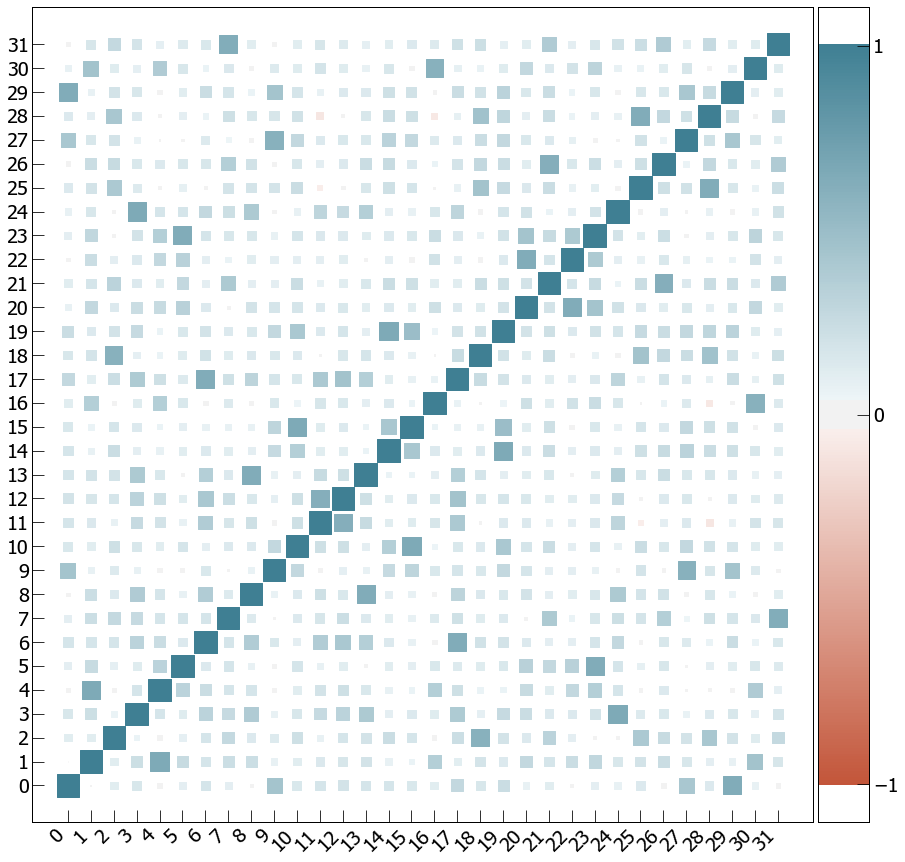

In [94]:
um_mx_classes_arrays = fs.rs['d5UltraMixed20bits'].classes_templates[0][5]
random.shuffle(um_mx_classes_arrays)
um_mx_classes_df = pd.DataFrame(np.vstack(um_mx_classes_arrays).transpose())

um_mx_classes_corr = um_mx_classes_df.corr(method='pearson')
um_mx_classes_corr = pd.melt(um_mx_classes_corr.reset_index(), id_vars='index').fillna(0) # Unpivot the dataframe, so we can get pair of arrays for x and y
um_mx_classes_corr.columns = ['x', 'y', 'value']

um_mx_htmp = heatmap(
    x=um_mx_classes_corr['x'],
    y=um_mx_classes_corr['y'],
    size=um_mx_classes_corr['value'].abs(),
    color=um_mx_classes_corr['value']
)

for fmt in ['svg', 'png', 'pdf']:
    um_mx_htmp.savefig(
        os.path.join(
            paths['plots'],
            'um_mx_classes_spatialCorr.{:s}'.format(fmt)
        ), format=fmt
    )

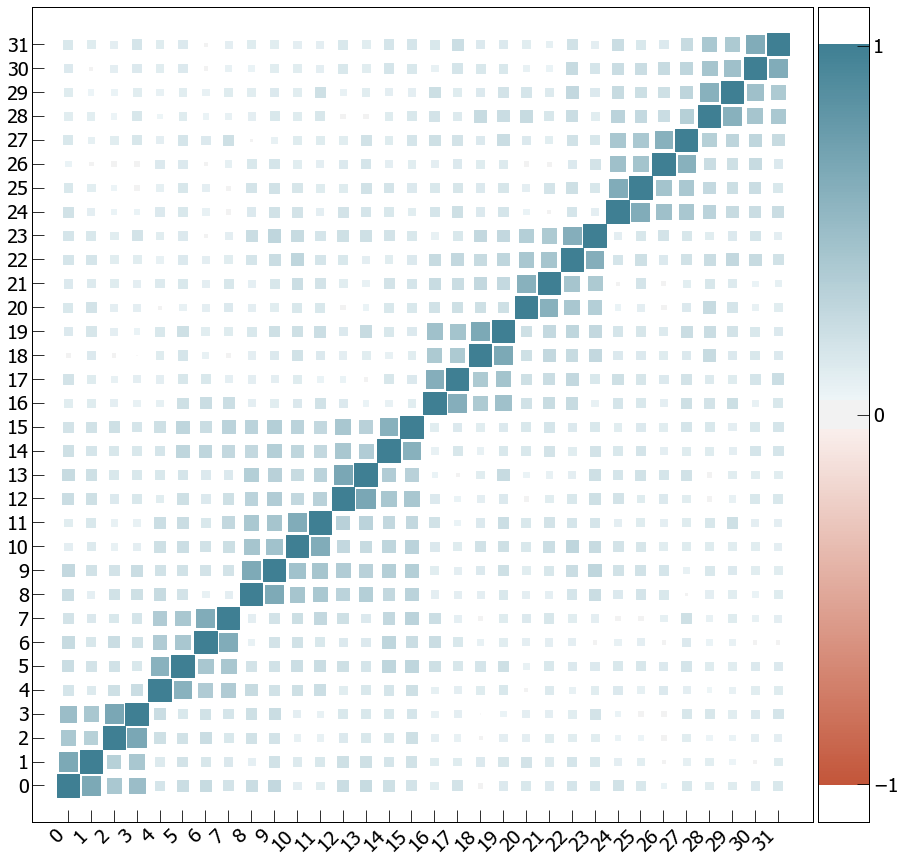

In [96]:
um_um_classes_arrays = fs.rs['d5UltraUnmixed20bits'].classes_templates[0][5]
um_um_classes_df = pd.DataFrame(np.vstack(um_um_classes_arrays).transpose())

um_um_classes_corr = um_um_classes_df.corr(method='pearson')
um_um_classes_corr = pd.melt(um_um_classes_corr.reset_index(), id_vars='index').fillna(0) # Unpivot the dataframe, so we can get pair of arrays for x and y
um_um_classes_corr.columns = ['x', 'y', 'value']

um_um_htmp = heatmap(
    x=um_um_classes_corr['x'],
    y=um_um_classes_corr['y'],
    size=um_um_classes_corr['value'].abs(),
    color=um_um_classes_corr['value']
)

for fmt in ['svg', 'png', 'pdf']:
    um_um_htmp.savefig(
        os.path.join(
            paths['plots'],
            'um_um_classes_spatialCorr.{:s}'.format(fmt)
        ), format=fmt
    )